# Exercise - Decision Tree

This data set for this exercise is from healthcare. It contains data about 10 years of clinical care at 130 US Hospitals. Each row represents a single patient. The columns include the characteristics of deidentified diabetes patients. This is a binary classification task: predict whether a diabetes patient is readmitted to the hospital within 30 days of their discharge (1=Yes, 0=No). This is an important performance metric for hospitals as they try to minimize these types of readmissions.

## Description of Variables

The description of variables are provided in "Healthcare (small) - Data Dictionary.docx"

## Goal

Use the **healthcare_small.csv** data set and build a model to predict **readmitted**. 

# Read and Prepare the Data

In [3]:
# Common imports

import pandas as pd
import numpy as np

np.random.seed(42)

# Get the data

In [4]:
#We will predict the "price" value in the data set:

diabetes = pd.read_csv("healthcare_small.csv")
diabetes.head()

,race,gender,age,admission_type,discharge_disposition,admission_source,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
0,Other,Female,70-80,2,3,1,14,32,3,15,0,0,0,9,1
1,Caucasian,Female,80-90,1,3,5,4,44,0,15,0,0,0,9,0
2,AfricanAmerican,Male,50-60,5,1,1,6,29,1,15,0,0,0,9,1
3,Caucasian,Female,50-60,1,1,6,3,47,0,10,0,0,0,4,0
4,AfricanAmerican,Female,40-50,3,1,1,4,92,0,15,0,0,0,7,0


# Split data (train/test)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(diabetes, test_size=0.3)

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

## Separate the target variable 

In [7]:
train_target = train['readmitted']
test_target = test['readmitted']

train_inputs = train.drop(['readmitted'], axis=1)
test_inputs = test.drop(['readmitted'], axis=1)

## Feature Engineering: Derive a new column

Examples:
- Whether the patient had any emergency visits or not
- Ratio of inpatient visits to outpatient visits
- Ratio of time in hospital to number of medications
- (etc.)

In [8]:
def new_col(df):
    
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()

    # Use the formula, though fill in 0s when the value is 0/0 (because 0/0 generates "nan" values)
    df1['time_in_hospital'] = (df1['time_in_hospital']/df1['num_medications']).fillna(0)

    # Replace the infinity values with 1 (because a value divided by 0 generates infinity)
    df1['time_in_hospital'].replace(np.inf, 1, inplace=True)

    return df1[['time_in_hospital']]
    # You can use this to check whether the calculation is made correctly:
    #return df1
    

#### We use Future Engineering to extract variables from the dataset and helps to create models with better accuracy values of train and test. 

#### From the above code we can observe, here we have created an new dataframe new_col(df)
d1['time_on_hospital'] = (df1['num_medications']/d1['num_medications']

#### Both time_on_hospital and num_medications are numeric variable.

#### Now, If the formula (time_on_hospital \ num_medication) sastifies the given condition the result will be a 0 if it doesn't satisfy, the result it will be replaced by 1

In [9]:
#Let's test the new function:

# Send the train set to the function we created
new_col(train)

,time_in_hospital
4166,0.210526
5546,0.500000
2957,0.105263
6329,0.200000
565,0.250000
...,...
5734,0.322581
5191,0.153846
5390,0.608696
860,0.071429


##  Identify the numeric, binary, and categorical columns

In [10]:
# Let's change some of the categorical variables' data type to object

train_inputs['admission_source'] = train_inputs['admission_source'].astype('object')
train_inputs['admission_type'] = train_inputs['admission_type'].astype('object')
train_inputs['discharge_disposition'] = train_inputs['discharge_disposition'].astype('object')

test_inputs['admission_source'] = test_inputs['admission_source'].astype('object')
test_inputs['admission_type'] = test_inputs['admission_type'].astype('object')
test_inputs['discharge_disposition'] = test_inputs['discharge_disposition'].astype('object')


In [11]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [12]:
numeric_columns

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [13]:
categorical_columns

['race',
 'gender',
 'age',
 'admission_type',
 'discharge_disposition',
 'admission_source']

In [14]:
feat_eng_columns = ['time_in_hospital', 'num_medications' ]  

# Pipeline

In [15]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [16]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [17]:
# Create a pipeline for the transformed column here
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [18]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('trans', my_new_column, feat_eng_columns)],   
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [19]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

<6066x65 sparse matrix of type '<class 'numpy.float64'>'
	with 90990 stored elements in Compressed Sparse Row format>

In [20]:
train_x.shape

(6066, 65)

# Tranform: transform() for TEST

In [21]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

<2600x65 sparse matrix of type '<class 'numpy.float64'>'
	with 38997 stored elements in Compressed Sparse Row format>

In [22]:
test_x.shape

(2600, 65)

# Calculate the Baseline

In [23]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_target)

DummyClassifier(strategy='most_frequent')

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
#Baseline Train Accuracy
dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_target, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.5313221233102539


In [26]:
#Baseline Test Accuracy
dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_target, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.5365384615384615


# Train a DT model

In [27]:
from sklearn.tree import DecisionTreeClassifier 

tree_clf = DecisionTreeClassifier(max_depth=5)

tree_clf.fit(train_x, train_target)

DecisionTreeClassifier(max_depth=5)

In [28]:
from sklearn.metrics import accuracy_score

### Calculate the accuracy

In [29]:
#Train accuracy:
train_y_pred = tree_clf.predict(train_x)

print(accuracy_score(train_target, train_y_pred))

0.6264424662050775


In [30]:
#Test accuracy:
test_y_pred = tree_clf.predict(test_x)

print(accuracy_score(test_target, test_y_pred))

0.605


In [31]:
# There are 65 columns, so there are 65 values for each column's importance
# Values are rounded to three decimals

np.round(tree_clf.feature_importances_,3)

array([0.008, 0.034, 0.   , 0.025, 0.   , 0.   , 0.545, 0.018, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.006,
       0.   , 0.   , 0.   , 0.022, 0.   , 0.   , 0.   , 0.005, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.037, 0.   , 0.054,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.08 , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.113, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.013, 0.   , 0.   , 0.   ,
       0.   , 0.041])

In [32]:
# The importance of the last column (i.e., the one we derived)

np.round(tree_clf.feature_importances_,3)[-1]

0.041

TypeError: can only concatenate str (not "numpy.int64") to str

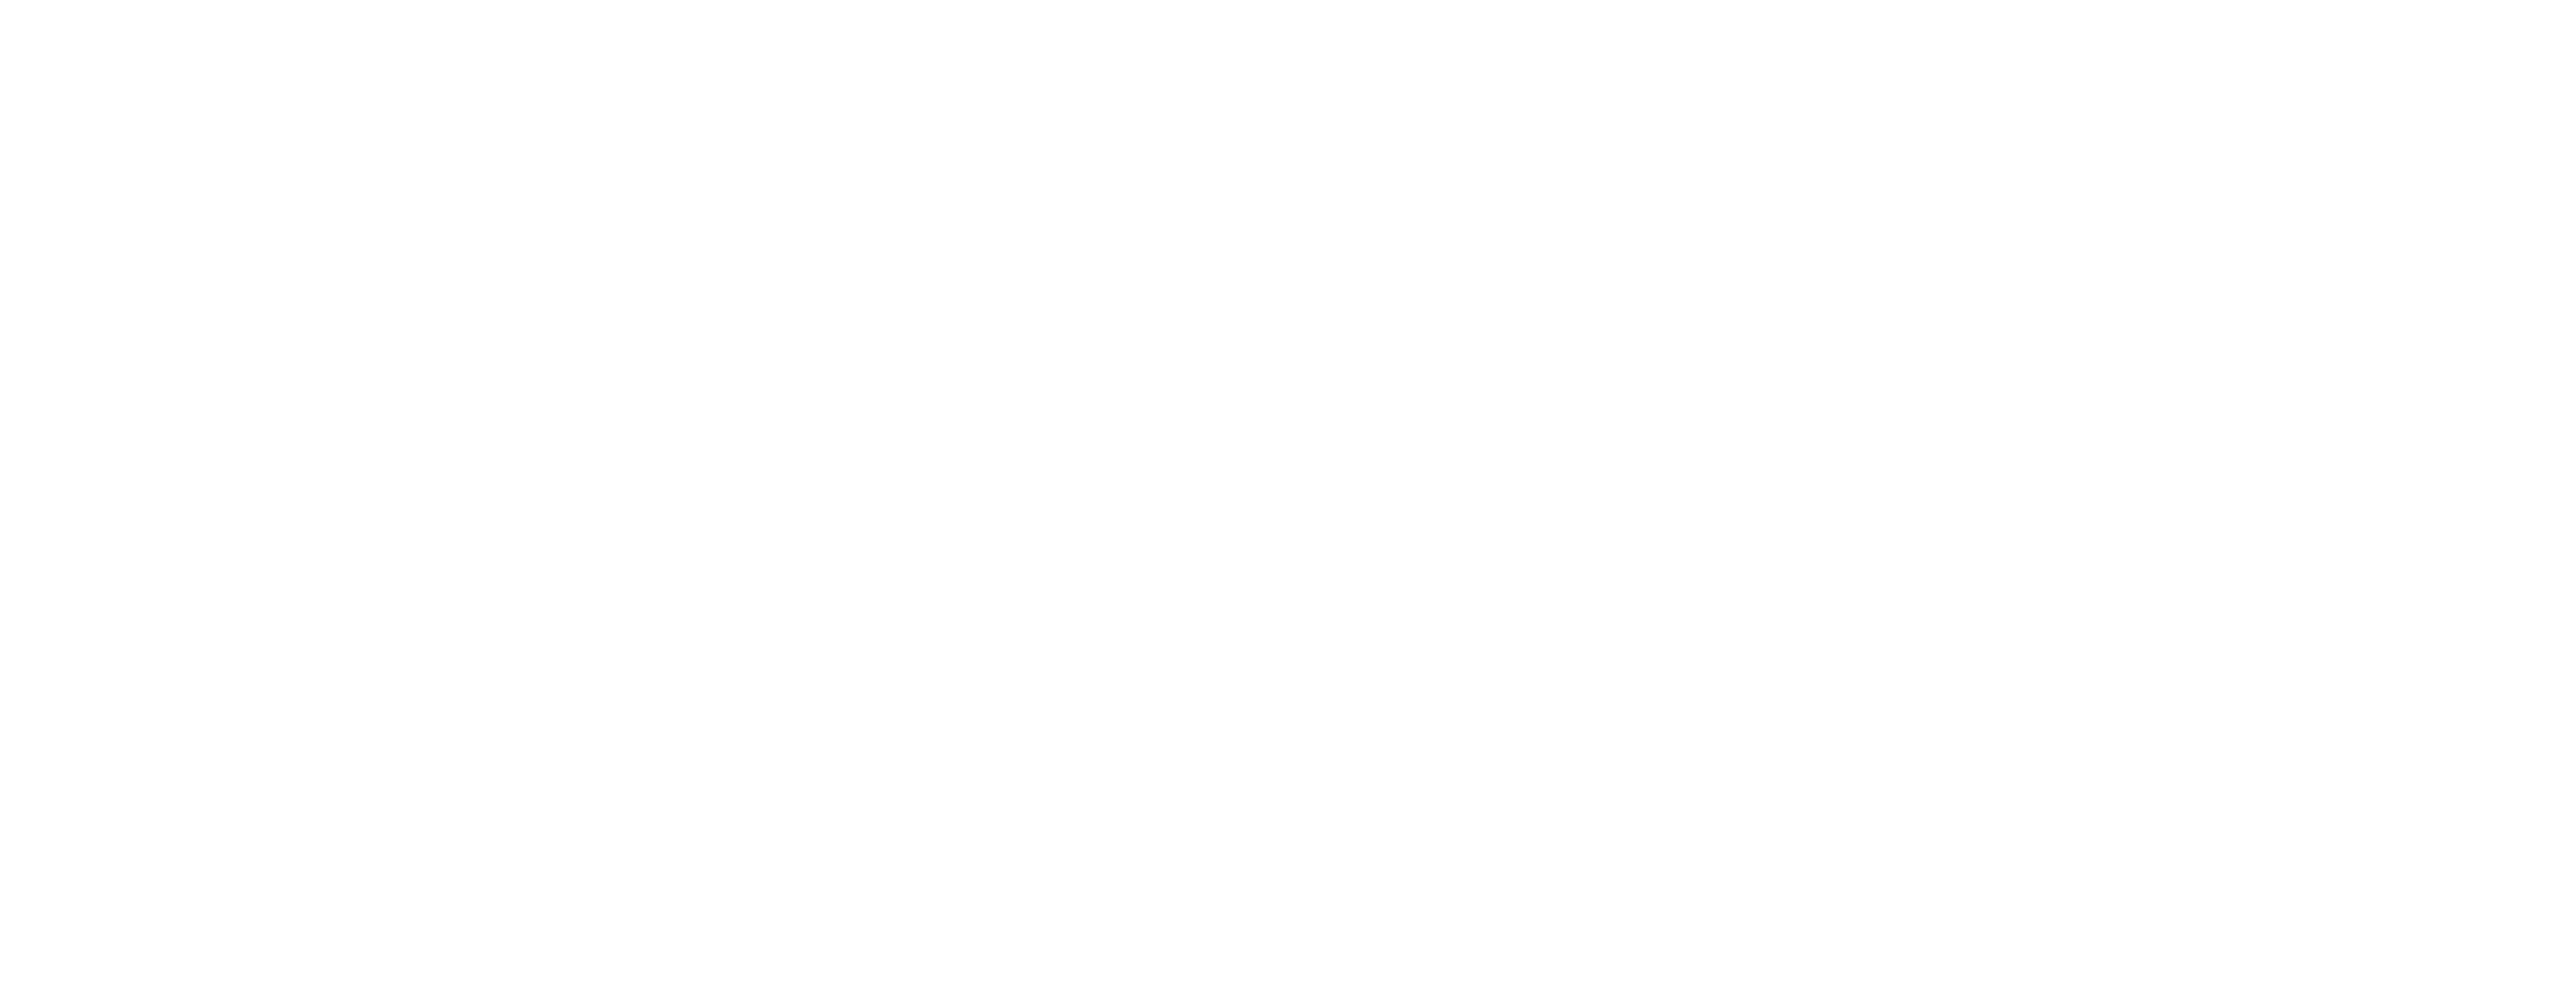

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))

tree = plot_tree(tree_clf, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=np.unique(train_target), 
              filled=True, 
              rounded=True, 
              fontsize=14)

# Train another DT model (with different parameters)

In [ ]:
from sklearn.dummy import DummyClassifier

tree_clf2 = DecisionTreeClassifier(min_samples_leaf = 10, max_depth=5)

tree_clf2.fit(train_x, train_target)

In [ ]:
from sklearn.metrics import accuracy_score

### Calculate the accuracy

In [ ]:
#Train accuracy:
train_y_pred = tree_clf2.predict(train_x)

print(accuracy_score(train_target, train_y_pred))

In [ ]:
#Test accuracy:
test_y_pred = tree_clf2.predict(test_x)

print(accuracy_score(test_target, test_y_pred))

In [ ]:
# There are 65 columns, so there are 65 values for each column's importance
# Values are rounded to three decimals

np.round(tree_clf.feature_importances_,3)

In [ ]:
# The importance of the last column (i.e., the one we derived)

np.round(tree_clf.feature_importances_,3)[-1]

# Optional: try grid search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {'max_depth': randint(low=5, high=20), 
              'min_samples_leaf': randint(low=5, high=20)}

tree_gs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, 
                             n_iter=15, cv=5, verbose=1,
                             scoring='accuracy',
                             return_train_score=True)

tree_gs.fit(train_x, train_target)g

In [ ]:
cvres = tree_gs.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

In [ ]:
#Find the best parameter set
tree_gs.best_params_

In [ ]:
tree_gs.best_estimator_

In [ ]:
#Train accuracy:
train_y_pred = tree_gs.best_estimator_.predict(train_x)

print(accuracy_score(train_target, train_y_pred))

In [ ]:
#Test accuracy:
test_y_pred = tree_gs.best_estimator_.predict(test_x)

print(accuracy_score(test_target, test_y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
#Test confusion matrix
confusion_matrix(test_target, test_y_pred)